# Project: Disaster Tweets 

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

In [1]:
#Loading the necessary libraries 

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re

import sklearn 
from sklearn import feature_extraction, model_selection, linear_model

import nltk 
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from tensorflow.python.framework.random_seed import set_random_seed

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

import scipy 
from scipy import sparse
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix

## EDA 

First, we look at the dataset. We can see that the two target classes are rather balanced in the training set (*real* disaster tweets: 3271, *fake* disaster tweets: 4342). 

We also observe that the id column doesn't provide any useful information and can be dropped. 

Moreover, analysis on the location column reveals that 30% of values are missing, and those that are there are expressed in a variety of formats (city, state, city+state...). Since location wouldn't probably have helped much our classification, as disasters can unfortunately happen anywhere, we discard this column as well. 

The keyword column seems to be useful, even with missing values. 

In [2]:
#Loading the dataset 

url1 = 'https://raw.githubusercontent.com/lila-97/Disaster-tweets-nlp/main/train.csv'
url2 = 'https://raw.githubusercontent.com/lila-97/Disaster-tweets-nlp/main/test.csv'
train_df = pd.read_csv(url1, sep=",")
test_df = pd.read_csv(url2, sep=",") 


# Exploring the dataset 

train_df.shape # The training set has 7613 rows and 5 columns 

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("The real disaster tweets are {}".format(len(train_df[train_df['target'] == 1])))
print("The fake disaster tweets are {}".format(len(train_df[train_df['target'] == 0])))
print()
print("Hence, the two classes are balanced, although we have slightly more fake than real tweets")

print("The missing values for the keyword column are: {}".format(train_df["keyword"].isna().sum()))
print("There are {} unique keywords in the dataframe".format(len(train_df["keyword"].unique())))
print()
print("The missing values for the location column are: {}".format(train_df["location"].isna().sum()))
print("There are {} unique locations in the dataframe".format(len(train_df["location"].unique())))
print()
print("""One can already assume that keywords are going to be more relevant than locations for classification, 
      as more than 30% of location values are missing""")

The real disaster tweets are 3271
The fake disaster tweets are 4342

Hence, the two classes are balanced, although we have slightly more fake than real tweets
The missing values for the keyword column are: 61
There are 222 unique keywords in the dataframe

The missing values for the location column are: 2533
There are 3342 unique locations in the dataframe

One can already assume that keywords are going to be more relevant than locations for classification, 
      as more than 30% of location values are missing


In [7]:
#Find out if there is duplicates and nans in text column 

train_df.duplicated().sum()
train_df['text'].isna().any()

False

In [5]:
# Dropping location column because of too many different location formats and id columns 
# since it gives us no info 
train_df['location'].unique()

#train_df = train_df.drop('location', axis=1)
train_df = train_df.drop('id', axis=1)
train_df = train_df.drop('location', axis=1)

In [6]:
# Check n of unique keywords and whether they are the same for train and test sets

print (train_df.keyword.nunique(), test_df.keyword.nunique())
print (set(train_df.keyword.unique()) - set(test_df.keyword.unique()))

## COPY CODE ABOUT UNIQUE KEYWORDS AND COMMENT (we use keyword since top 10 keywords are not same)

train_df.head()

221 221
set()


,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Text Preprocessing 

We now turn to preprocess the text of the two columns left, 'text' and 'keyword'. 

Looking at the unique values of 'keyword' column, we can immediately see that there are special characters instead of spaces, so we remove those and put spaces instead. 

We also remove special characters and urls from both columns thanks to utility functions. 

While the column 'text' has no missing values in it, the 'keyword' column does. We set those to 0 and convert to strings. This shouldn't affect our analysis (we will use CountVectorizer and none of the non-missing values have 0 in them so it should create a different token). 



In [8]:
#Keyword column:

#there are weird characters instead of spaces, quick fix for both test and training set 

train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20',' ')

In [9]:
# The keyword column actually seems useful, let's keep it 

# Utility functions for cleaning text of tweets 
def url_remover(text):
    text1 = re.sub(r'http?:\/\/.*[\r\n]*', "", text)
    text2 = re.sub(r'https:\/\/.*[\r\n]*', "", text1)
    text3 = " ".join(word for word in text2.split() if not word.startswith('@'))
    return text3.casefold().strip()

def special_chars_remover(text):
    text1 = re.sub(r"[^a-zA\s]", "", text)
    text2 = text1.replace("#", "").strip()
    #text2 = ' '.join(filter(str.isalnum, text2))
    return text2.strip()

# Applying functions to the training and test sets 
train_df['text'] = train_df.text.apply(url_remover)

train_df['text'] = train_df.text.apply(special_chars_remover)


test_df["text"] = test_df.text.apply(url_remover)


test_df["text"] = test_df.text.apply(special_chars_remover)

In [10]:
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    people receive wildfires evacuation orders in ...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [11]:
test_df['text'].head()

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object

In [12]:
X_train = train_df[['text', 'keyword']]
y_train = train_df['target']

X_test = test_df[['text', 'keyword']]

# Replace nans in keyword columns with zeroes 

X_train['keyword'] = X_train['keyword'].fillna(0)
X_train['keyword'] = X_train['keyword'].astype(str)
X_test['keyword'] = X_test['keyword'].fillna(0)
X_test['keyword'] = X_test['keyword'].astype(str)

<ipython-input-12-af780f71820a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].fillna(0)
<ipython-input-12-af780f71820a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].astype(str)
<ipython-input-12-af780f71820a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [13]:
print("X_train dim after processing: {}".format(X_train.shape))
print("y_train dim after processing: {}".format(y_train.shape))
print("X_test dim after processing: {}".format(X_test.shape))
X_train.head()

X_train dim after processing: (7613, 2)
y_train dim after processing: (7613,)
X_test dim after processing: (3263, 2)


,text,keyword
0,our deeds are the reason of this earthquake ma...,0
1,forest fire near la ronge sask canada,0
2,all residents asked to shelter in place are be...,0
3,people receive wildfires evacuation orders in ...,0
4,just got sent this photo from ruby alaska as s...,0


## Tokenization and Tf-Idf transformation 

The commented code below shows a precedent attempt at tokenizing the text of both text and keyword columns using CountVectorizer(). This approach, however, reached only suboptimal accuracy for all methods attempted. 
Hence, we perform tokenization through TfidfVectorizer(), which reaches better results. 
TfidfVectorizer() actually performs automatically stopword removal, tokenization and n-grams creation, so that is why they have not been performed manually. 

In [14]:
#count_vectorizer1 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=200,
                                                            #min_df = 6,
                                                          #stop_words='english')

#count_vectorizer2 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=10,
                                                            #min_df = 2,
                                                          #stop_words='english')

#train_vectors1 = pd.DataFrame(count_vectorizer.fit_transform(X_train['text']))
#train_vectors2 = pd.DataFrame(count_vectorizer.fit_transform(X_train['keyword']))
#X_train = pd.concat([train_vectors1, train_vectors2], axis=1)


#train_vectors1 =count_vectorizer1.fit_transform(X_train['text'])

#type(train_vectors1)

#print("vocabulary of text column is {}".format(count_vectorizer1.vocabulary_))

#train_vectors2 = count_vectorizer2.fit_transform(X_train['keyword'])

#print("vocabulary of keyword column is {}".format(count_vectorizer2.vocabulary_))

#import scipy
#from scipy.sparse import coo_matrix, hstack

#test_vectors1 = count_vectorizer1.transform(X_test['text'])
#test_vectors2 = count_vectorizer2.transform(X_test['keyword'])

#Creating X_train, y_train, X_test and y_test

#X_train = scipy.sparse.hstack([train_vectors1, train_vectors2])
#X_train.shape

#X_test = scipy.sparse.hstack([test_vectors1, test_vectors2])

#X_test.shape

In [ ]:
#For tf-idf, better to transform text column tweets into lists of sentences (?) 

In [17]:
# Tf-idf for text and keyword columns

tf_vec = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences and unigrams and bigrams

text_vectors_tr = tf_vec.fit_transform(X_train['text'])
key_vectors_tr = tf_vec.fit_transform(X_train['keyword'])



tot_vectors_tr = scipy.sparse.hstack([text_vectors_tr, key_vectors_tr])
text_vectors_ts = tf_vec.transform(X_test['text'])

key_vectors_ts = tf_vec.transform(X_test['keyword'])
tot_vectors_ts = scipy.sparse.hstack([text_vectors_ts, key_vectors_ts])

text_vectors_tr.shape

X_train = pd.DataFrame(tot_vectors_tr.toarray())
X_test = pd.DataFrame(tot_vectors_ts.toarray())
print (X_train.shape)
print(X_test.shape)

(7613, 1815)
(3263, 506)


## Logistic Regression

As a benchmark model we try the basic logistic regression. 
Validation set accuracy: 79.3% 

In [19]:
#Split in training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  train_size = 0.7, random_state = 123)

param_grid_test = {
    'C': [0.1, 0.5, 1, 5, 10, 15, 20],
    'fit_intercept': [True, False]
}

#target classifier
lr = LogisticRegression(max_iter = 300, random_state=123)

#grid-search object
clf_lr = GridSearchCV(estimator= lr, param_grid=param_grid_test, 
                   cv = 10, scoring = "accuracy")



In [20]:
clf_lr.fit(X_train, y_train)

y_train_pred_lr = clf_lr.predict(X_train)
y_val_pred_lr = clf_lr.predict(X_val)


print(clf_lr.best_params_)
print(clf_lr.best_score_)
print(f"Logistic Regression.\tTrain ACC: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"Logistic Regression.\tVal ACC: {accuracy_score(y_val, y_val_pred_lr)}")

{'C': 0.5, 'fit_intercept': True}
0.7887062872942205
Logistic Regression.	Train ACC: 0.8431225370613623
Logistic Regression.	Val ACC: 0.7937828371278459


## KNN

We also try K-Nearest-Neighbours. First, we need to find for which value of K the algorithm reaches highest accuracy on the validation set. As it doesn't seem to ever go over 75% for validation set, we discard this model. 

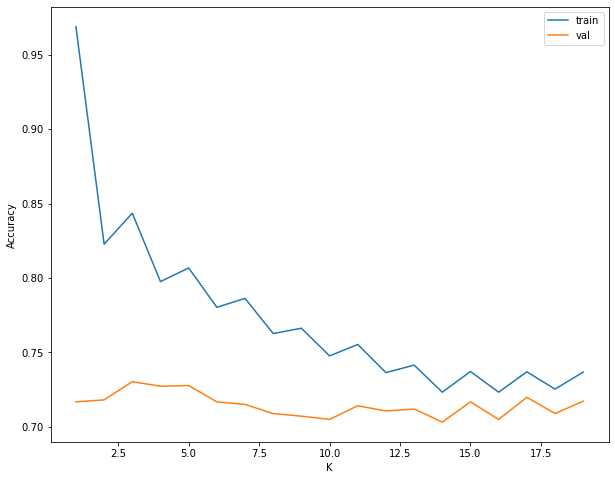

In [21]:
from sklearn.neighbors import KNeighborsClassifier


accuracy_values_train = []
accuracy_values_val = []
k_values = range(1, 20)


for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_val = model.predict(X_val)
  accuracy_values_train.append(accuracy_score(y_pred_train, y_train))
  accuracy_values_val.append(accuracy_score(y_pred_val, y_val))

    
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, accuracy_values_train, label="train")
plt.plot(k_values, accuracy_values_val, label="val")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Decision Trees 

Then, we try Decision tree algorithm. 

In [22]:
from sklearn import tree

param_grid_test = {
    'max_depth': [50,100,120,150,175,200,300,500],
    'max_features': [100,150,200],
    'min_samples_leaf':[1,3,5,7]
}

#target classifier
tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=123)

#grid-search object
clf_tree = GridSearchCV(estimator= tree, param_grid=param_grid_test, 
                   cv = 10, scoring = "accuracy")


In [ ]:

clf_tree.fit(X_train, y_train)

y_train_pred_tree = clf_tree.predict(X_train)
y_val_pred_tree = clf_tree.predict(X_val)

print(f"Decision Tree.\tTrain ACC: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"Decision Tree.\tVal ACC: {accuracy_score(y_val, y_val_pred_lr)}")

In [ ]:
sklearn.set_config(print_changed_only=False)

clf_tree

## Neural Networks 

Then, we try some neural nets models. 

In [ ]:
# Converting y_train from (0,1) to (1,-1) and other params definition 

feature_vector_length = 210
num_classes = 2


print(y_train)

y_train_nn = np.where(y_train==0, -1, y_train) 

type(y_train_nn)
np.unique(y_train_nn)

In [ ]:
# Configuration options
#see the number of labels
labels = set(y_train)
print(labels, len(labels))

In [ ]:
# Configuration options
feature_vector_length = X_train.shape[1] #how many features
num_classes = len(labels) #how many classes

print(feature_vector_length, num_classes)

y_train_cat = to_categorical(y_train, num_classes)

In [ ]:
np.random.seed(123)
set_random_seed(2)

model = Sequential() #we first define how the "model" looks like
model.add(Dense(input_dim = feature_vector_length, units=feature_vector_length , activation='relu')) #input layer
model.add(Dense(num_classes, activation='softmax')) #output layer
print(model.summary())
#plot_model(model, show_shapes= True)

In [ ]:
model.compile(loss='categorical_crossentropy', #loss metric
    optimizer='sgd',  #optimizer
    metrics=['accuracy']) #displayed metric


#fit
history = model.fit(X_train, y_train_cat, epochs=5, batch_size=8, verbose=1, validation_split=0.1)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.ylim(0.8, 1)
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()